Actual selection rate in dataset: 0.0020
Calibrated intercept used: -11.595


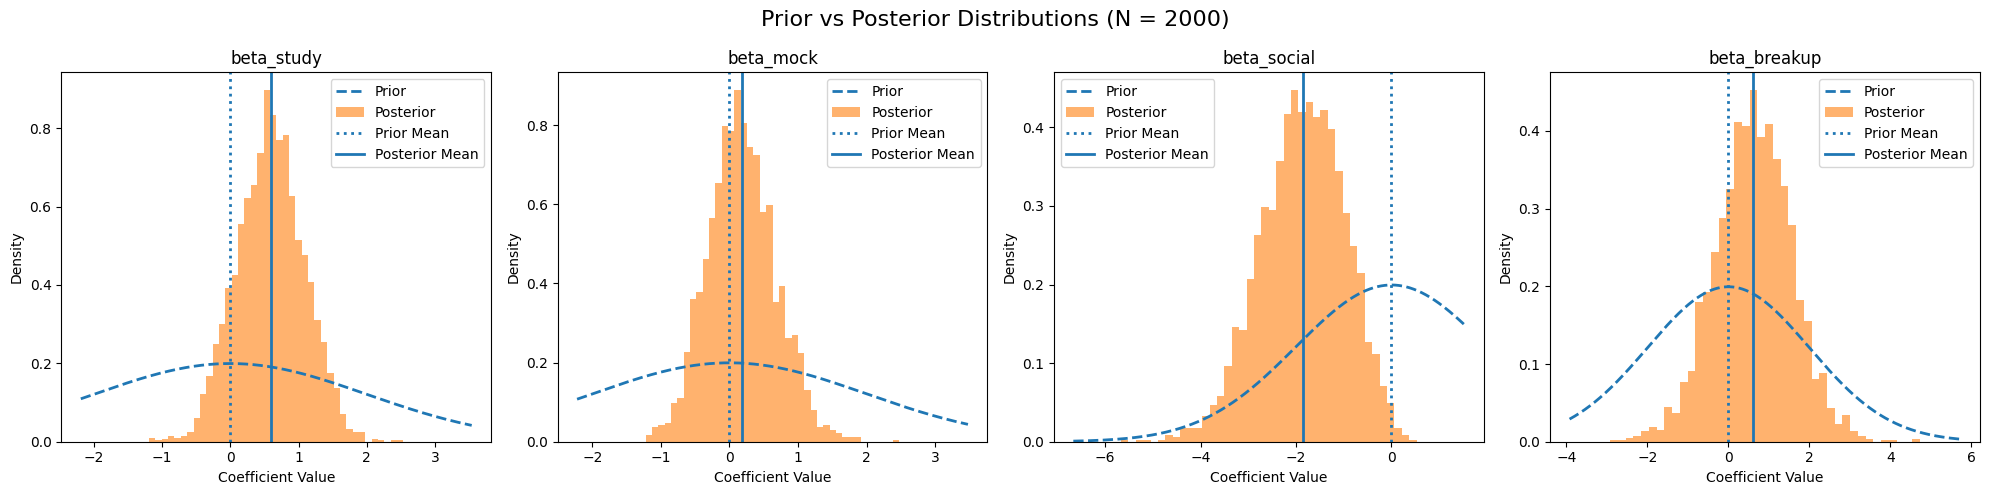


Posterior Mean and Standard Deviation:

beta0            Mean = -7.991   SD = 1.041
beta_study       Mean = 0.590   SD = 0.490
beta_mock        Mean = 0.180   SD = 0.493
beta_social      Mean = -1.858   SD = 0.875
beta_breakup     Mean = 0.619   SD = 0.947

Enter candidate details:

Study hours per week: 63
Mock performance (0–1): 0.6
Social media hours per day: 2
Breakup happened? (1=Yes, 0=No): 0

===== Individual Selection Probability =====
Mean Probability: 0.008605
95% Credible Interval: [0.000267, 0.040311]


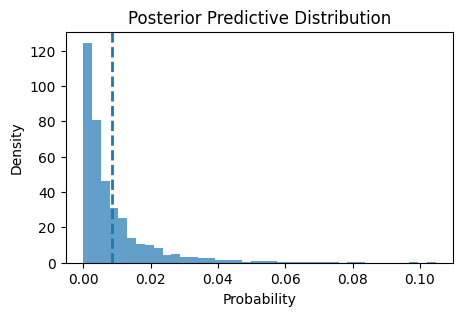

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

np.random.seed(42)

N = 2000
target_rate = 0.003   # 0.3%

# True slopes
beta_study_true = 0.08
beta_mock_true = 3.0
beta_social_true = -0.25
beta_breakup_true = 0.4

def generate_data(N):

    study = np.random.normal(50, 5, N)
    mock = np.random.beta(8, 3, N)
    social = np.random.lognormal(1, 0.5, N)
    breakup = np.random.binomial(1, 0.3, N)

    linear_part = (beta_study_true * study + beta_mock_true * mock + beta_social_true * social + beta_breakup_true * breakup)


    def rate_difference(beta0):
        p = 1 / (1 + np.exp(-(beta0 + linear_part)))
        return np.mean(p) - target_rate

    beta0_true = brentq(rate_difference, -50, 10)

    logit_p = beta0_true + linear_part
    p = 1 / (1 + np.exp(-logit_p))
    success = np.random.binomial(1, p)

    return study, mock, social, breakup, success, beta0_true

study, mock, social, breakup, y, beta0_true = generate_data(N)

print(f"Actual selection rate in dataset: {np.mean(y):.4f}")
print(f"Calibrated intercept used: {beta0_true:.3f}")

study_mean, study_std_dev = np.mean(study), np.std(study)
mock_mean, mock_std_dev = np.mean(mock), np.std(mock)
social_mean, social_std_dev = np.mean(social), np.std(social)

study_std = (study - study_mean) / study_std_dev
mock_std = (mock - mock_mean) / mock_std_dev
social_std = (social - social_mean) / social_std_dev

with pm.Model() as model:

    beta0 = pm.Normal("beta0", 0, 5)
    beta_study = pm.Normal("beta_study", 0, 2)
    beta_mock = pm.Normal("beta_mock", 0, 2)
    beta_social = pm.Normal("beta_social", 0, 2)
    beta_breakup = pm.Normal("beta_breakup", 0, 2)

    logit_p = (beta0 + beta_study * study_std + beta_mock * mock_std + beta_social * social_std + beta_breakup * breakup)

    p = pm.math.sigmoid(logit_p)
    y_obs = pm.Bernoulli("y", p=p, observed=y)

    trace = pm.sample(1500,tune=1000, chains=2,target_accept=0.9, progressbar=False)

coeff_names = ["beta_study", "beta_mock", "beta_social", "beta_breakup"]

fig, axes = plt.subplots(1, len(coeff_names), figsize=(20, 5))

for i, coeff in enumerate(coeff_names):

    ax = axes[i]
    posterior_samples = trace.posterior[coeff].values.flatten()

    x_min = posterior_samples.min() - 1
    x_max = posterior_samples.max() + 1
    x = np.linspace(x_min, x_max, 1000)

    prior_pdf = norm.pdf(x, 0, 2)
    ax.plot(x, prior_pdf, linestyle="--", linewidth=2, label="Prior")

    ax.hist(posterior_samples,bins=40,density=True,alpha=0.6,label="Posterior")

    ax.axvline(0, linestyle=":", linewidth=2, label="Prior Mean")

    posterior_mean = posterior_samples.mean()
    ax.axvline(posterior_mean,linestyle="-",linewidth=2,label="Posterior Mean")

    ax.set_title(coeff)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Density")
    ax.legend()

plt.suptitle(f"Prior vs Posterior Distributions (N = {N})",fontsize=16)

plt.tight_layout()
plt.show()

summary = az.summary(trace, round_to=3)

print("\nPosterior Mean and Standard Deviation:\n")
for b in ["beta0", "beta_study", "beta_mock", "beta_social", "beta_breakup"]:
    mean = summary.loc[b, "mean"]
    sd = summary.loc[b, "sd"]
    print(f"{b:15s}  Mean = {mean:.3f}   SD = {sd:.3f}")

def predict_selection_probability(study_hours, mock_score, social_hours, breakup_status):

    study_s = (study_hours - study_mean) / study_std_dev
    mock_s = (mock_score - mock_mean) / mock_std_dev
    social_s = (social_hours - social_mean) / social_std_dev

    beta0_samples = trace.posterior["beta0"].values.flatten()
    beta_study_samples = trace.posterior["beta_study"].values.flatten()
    beta_mock_samples = trace.posterior["beta_mock"].values.flatten()
    beta_social_samples = trace.posterior["beta_social"].values.flatten()
    beta_breakup_samples = trace.posterior["beta_breakup"].values.flatten()

    logit_samples = (beta0_samples + beta_study_samples * study_s + beta_mock_samples * mock_s + beta_social_samples * social_s + beta_breakup_samples * breakup_status)

    prob_samples = 1 / (1 + np.exp(-logit_samples))

    mean_prob = np.mean(prob_samples)
    lower = np.percentile(prob_samples, 2.5)
    upper = np.percentile(prob_samples, 97.5)

    print("\n===== Individual Selection Probability =====")
    print(f"Mean Probability: {mean_prob:.6f}")
    print(f"95% Credible Interval: [{lower:.6f}, {upper:.6f}]")

    plt.figure(figsize=(5,3))
    plt.hist(prob_samples, bins=40, density=True, alpha=0.7)
    plt.axvline(mean_prob, linestyle="--", linewidth=2)
    plt.title("Posterior Predictive Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.show()


print("\nEnter candidate details:\n")

study_input = float(input("Study hours per week: "))
mock_input = float(input("Mock performance (0–1): "))
social_input = float(input("Social media hours per day: "))
breakup_input = int(input("Breakup happened? (1=Yes, 0=No): "))

predict_selection_probability(study_input,mock_input,social_input,breakup_input)